In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gauravkumar2525/bitcoin-market-hourly-trends-2024-2025")

print("Path to dataset files:", path)

100%|██████████| 199k/199k [00:00<00:00, 55.6MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/gauravkumar2525/bitcoin-market-hourly-trends-2024-2025/versions/1


In [12]:
import pandas as pd
import os

# The path to the downloaded dataset from the previous step
dataset_path = "/root/.cache/kagglehub/datasets/gauravkumar2525/bitcoin-market-hourly-trends-2024-2025/versions/1"

# List files in the dataset directory to find the correct CSV file name
try:
    files = os.listdir(dataset_path)
    print("Files in the dataset directory:", files)

    # Assuming the CSV file is the only one or has a specific name pattern
    # You might need to adjust the filename below based on the output of the listdir command
    csv_file_name = "btc_hourly_ohlcv.csv" # Replace with the actual CSV file name if different
    csv_file_path = os.path.join(dataset_path, csv_file_name)

    df = pd.read_csv(csv_file_path)
    print("\nDataset loaded successfully.")
    display(df.head())

except FileNotFoundError:
    print(f"Error: The directory {dataset_path} was not found.")
except Exception as e:
    print(f"An error occurred while loading the dataset: {e}")

Files in the dataset directory: ['btc_hourly_ohlcv.csv']

Dataset loaded successfully.


,timestamp,open,high,low,close,volume
0,2024-03-16 19:00:00,67030.60,67699.00,66890.20,66911.52,3261.62146
1,2024-03-16 20:00:00,66911.51,67538.49,66739.81,67129.19,2592.04897
2,2024-03-16 21:00:00,67129.19,67241.10,66015.89,66243.28,3430.96214
3,2024-03-16 22:00:00,66243.29,66786.44,65804.00,66361.11,2832.31710
4,2024-03-16 23:00:00,66361.11,66375.07,64780.00,65300.63,6594.27793


In [13]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Display data types
print("\nData types of each column:")
print(df.dtypes)

Missing values in each column:
timestamp    0
open         0
high         0
low          0
close        0
volume       0
dtype: int64

Data types of each column:
timestamp     object
open         float64
high         float64
low          float64
close        float64
volume       float64
dtype: object


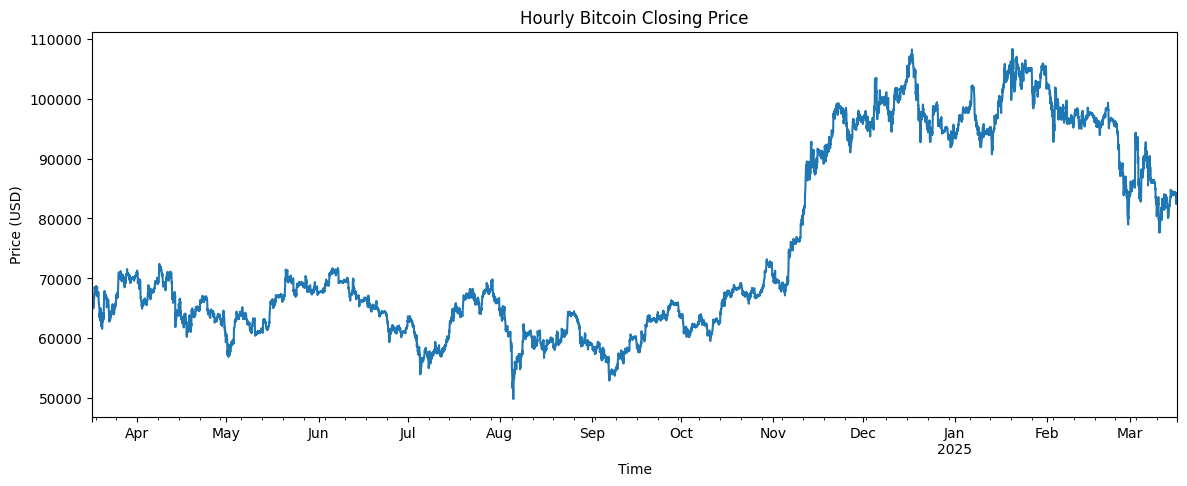

In [14]:
import matplotlib.pyplot as plt

# Convert 'timestamp' to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Set 'timestamp' as the index for time series plotting
df.set_index('timestamp', inplace=True)

# Visualize the 'close' price
df['close'].plot(figsize=(14, 5), title="Hourly Bitcoin Closing Price")
plt.ylabel('Price (USD)')
plt.xlabel('Time')
plt.show()

In [15]:
# Save the cleaned dataset to a new CSV file
output_filename = "cleaned_bitcoin_hourly_data.csv"
df.to_csv(output_filename)

print(f"Cleaned dataset saved to '{output_filename}'")

Cleaned dataset saved to 'cleaned_bitcoin_hourly_data.csv'


In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import joblib
import numpy as np

# Data Preparation for regression
# We'll use 'open', 'high', 'low', and 'volume' to predict 'close'

features = ['open', 'high', 'low', 'volume']
target = 'close'

X = df[features].values
y = df[target].values

# Scale the features (X)
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Scale the target variable (y)
scaler_y = MinMaxScaler()
# Reshape y to be a 2D array as required by MinMaxScaler
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Train the Linear Regression model
linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train, y_train)

# Save the scalers and the trained model
joblib.dump(scaler_X, 'linear_regression_scaler_X.pkl')
joblib.dump(scaler_y, 'linear_regression_scaler_y.pkl')
joblib.dump(linear_regression_model, 'linear_regression_model.pkl')

print("Linear Regression model trained and saved.")

Linear Regression model trained and saved.


In [17]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Make predictions on training and test sets
y_train_pred_scaled = linear_regression_model.predict(X_train)
y_test_pred_scaled = linear_regression_model.predict(X_test)

# Inverse transform the predictions and actual values to original scale
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
y_train_orig = scaler_y.inverse_transform(y_train)
y_test_orig = scaler_y.inverse_transform(y_test)

# Calculate metrics for training set
train_mse = mean_squared_error(y_train_orig, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train_orig, y_train_pred)
# Avoid division by zero in MAPE if y_train_orig contains zero
train_mape = np.mean(np.abs((y_train_orig - y_train_pred) / y_train_orig)) * 100 if not np.any(y_train_orig == 0) else np.nan


# Calculate metrics for test set
test_mse = mean_squared_error(y_test_orig, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test_orig, y_test_pred)
# Avoid division by zero in MAPE if y_test_orig contains zero
test_mape = np.mean(np.abs((y_test_orig - y_test_pred) / y_test_orig)) * 100 if not np.any(y_test_orig == 0) else np.nan


# Print the metrics
print("Training Metrics:")
print(f"  Mean Squared Error (MSE): {train_mse:.4f}")
print(f"  Root Mean Squared Error (RMSE): {train_rmse:.4f}")
print(f"  R-squared (R2): {train_r2:.4f}")
print(f"  Mean Absolute Percentage Error (MAPE): {train_mape:.4f}%")

print("\nTest Metrics:")
print(f"  Mean Squared Error (MSE): {test_mse:.4f}")
print(f"  Root Mean Squared Error (RMSE): {test_rmse:.4f}")
print(f"  R-squared (R2): {test_r2:.4f}")
print(f"  Mean Absolute Percentage Error (MAPE): {test_mape:.4f}%")

Training Metrics:
  Mean Squared Error (MSE): 37683.2642
  Root Mean Squared Error (RMSE): 194.1218
  R-squared (R2): 0.9998
  Mean Absolute Percentage Error (MAPE): 0.1715%

Test Metrics:
  Mean Squared Error (MSE): 36949.1045
  Root Mean Squared Error (RMSE): 192.2215
  R-squared (R2): 0.9998
  Mean Absolute Percentage Error (MAPE): 0.1753%


In [18]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import joblib

# Data Preparation for LSTM
# We'll use 'open', 'high', 'low', and 'volume' to predict 'close'

features = ['open', 'high', 'low', 'volume']
target = 'close'

X = df[features].values
y = df[target].values

# Scale the features (X)
scaler_X_lstm = MinMaxScaler()
X_scaled_lstm = scaler_X_lstm.fit_transform(X)

# Scale the target variable (y)
scaler_y_lstm = MinMaxScaler()
# Reshape y to be a 2D array as required by MinMaxScaler
y_scaled_lstm = scaler_y_lstm.fit_transform(y.reshape(-1, 1))

# Save the scalers
joblib.dump(scaler_X_lstm, 'lstm_scaler_X.pkl')
joblib.dump(scaler_y_lstm, 'lstm_scaler_y.pkl')


# Function to create sequences for LSTM
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Define the number of time steps
TIME_STEPS = 24 # Using 24 hours of data to predict the next hour

X_sequences, y_sequences = create_sequences(X_scaled_lstm, y_scaled_lstm, TIME_STEPS)

print(f"Shape of X_sequences: {X_sequences.shape}")
print(f"Shape of y_sequences: {y_sequences.shape}")

Shape of X_sequences: (8736, 24, 4)
Shape of y_sequences: (8736, 1)


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.metrics import MeanAbsolutePercentageError

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_sequences.shape[1], X_sequences.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1))

# Compile the model
model_lstm.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanAbsolutePercentageError()])

# Display the model summary
model_lstm.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 50)         │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,251 (122.07 KB)

 Trainable params: 31,251 (122.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 0.0166 - mean_absolute_percentage_error: 68732.9922 - val_loss: 3.3644e-04 - val_mean_absolute_percentage_error: 4.1013
Epoch 2/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.0024 - mean_absolute_percentage_error: 33511.7734 - val_loss: 4.4344e-04 - val_mean_absolute_percentage_error: 4.7114
Epoch 3/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 0.0021 - mean_absolute_percentage_error: 4712.3438 - val_loss: 3.4978e-04 - val_mean_absolute_percentage_error: 4.0857
Epoch 4/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 0.0019 - mean_absolute_percentage_error: 20938.1074 - val_loss: 3.5125e-04 - val_mean_absolute_percentage_error: 4.4300
Epoch 5/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.0014 - mean_absolute_percentage_error: 30487.8477 - val_loss: 8.1048e-04 - val_mean_absolute_percentage_error: 8.5897
Epoch 6/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 0.0015 - mean_absolute_percentag

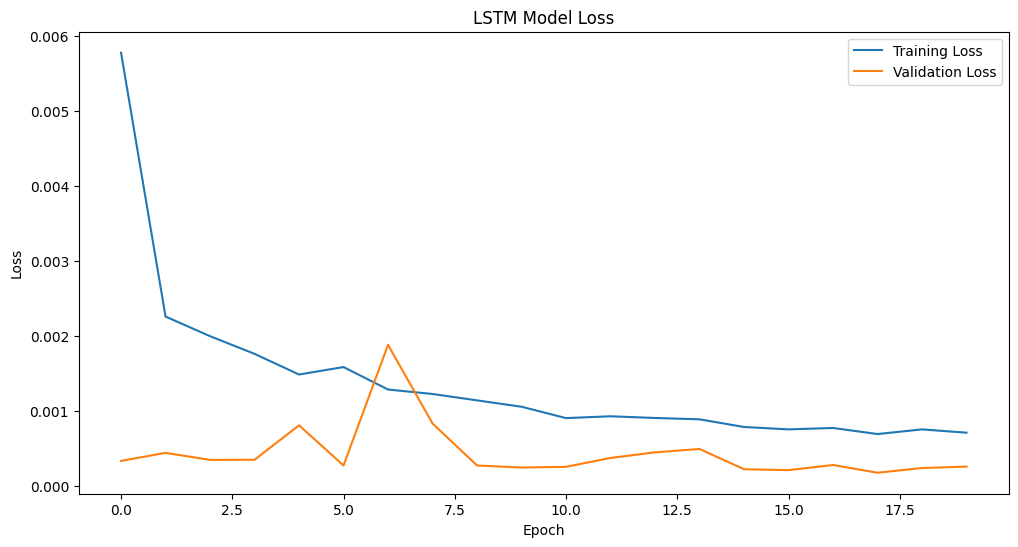


Final Training Loss: 0.0007123511168174446
Final Validation Loss: 0.0002604787005111575

LSTM model saved as 'lstm_model.h5'


In [20]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib

# Split data into training and validation sets for LSTM
X_train_lstm, X_val_lstm, y_train_lstm, y_val_lstm = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)

# Train the LSTM model
history = model_lstm.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=20, validation_split=0.2)

# Visualize training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Print final loss metrics
print("\nFinal Training Loss:", history.history['loss'][-1])
print("Final Validation Loss:", history.history['val_loss'][-1])

# Save the LSTM model
model_lstm.save('lstm_model.h5')
print("\nLSTM model saved as 'lstm_model.h5'")

In [21]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model

# Define the number of time steps (should be the same as used for training)
TIME_STEPS = 24

# Select the last 'TIME_STEPS' data points from the original dataframe as new data for prediction
# This is for demonstration purposes as we don't have truly 'new' data
# In a real scenario, you would load your new data here
new_data = df.tail(TIME_STEPS)

# Extract features and target from the new data
features = ['open', 'high', 'low', 'volume']
X_new = new_data[features].values

# Load the scalers and the LSTM model
try:
    scaler_X_lstm = joblib.load('lstm_scaler_X.pkl')
    scaler_y_lstm = joblib.load('lstm_scaler_y.pkl')
    model_lstm = load_model('lstm_model.h5')
    print("Scalers and LSTM model loaded successfully.")
except FileNotFoundError:
    print("Error: Scaler or model files not found. Please ensure 'lstm_scaler_X.pkl', 'lstm_scaler_y.pkl', and 'lstm_model.h5' exist.")
    exit()
except Exception as e:
    print(f"An error occurred while loading files: {e}")
    exit()

# Scale the new features
X_new_scaled = scaler_X_lstm.transform(X_new)

# Reshape the new data for LSTM input (samples, time steps, features)
# Since we are predicting the next step, we create a single sequence from the last TIME_STEPS
if len(X_new_scaled) == TIME_STEPS:
    X_new_sequence = X_new_scaled.reshape(1, TIME_STEPS, len(features))

    # Make prediction
    predictions_scaled = model_lstm.predict(X_new_sequence)

    # Inverse transform the prediction to original scale
    predictions = scaler_y_lstm.inverse_transform(predictions_scaled)

    # Get the timestamp for the prediction (the next hour after the last data point)
    last_timestamp = new_data.index[-1]
    prediction_timestamp = last_timestamp + pd.Timedelta(hours=1)

    # Create a DataFrame for the prediction
    df_prediction = pd.DataFrame(predictions, index=[prediction_timestamp], columns=['predicted_close_price'])

    print("\nPredicted Bitcoin Closing Price for the next hour:")
    print(df_prediction)

else:
    print(f"Not enough data points ({len(X_new_scaled)}) to create a sequence of length {TIME_STEPS}. Need exactly {TIME_STEPS} for this prediction method.")

Scalers and LSTM model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step

Predicted Bitcoin Closing Price for the next hour:
                     predicted_close_price
2025-03-16 19:00:00           83292.078125
